In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle
import itertools
from sklearn import base, model_selection, metrics, discriminant_analysis, pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import constants
import dataset
import folders

import classification_functions as cf

In [2]:
plt.rcParams['figure.figsize']=(1,5)
plt.rcParams['figure.dpi'] = 200 
plt.rcParams['savefig.dpi'] = 200

sns.set(font_scale=1, palette='colorblind') 
sns.set_context(context='paper')
sns.set_style("white")

The basic classification pipeline is implemented in classification_functions.py. It's supposed to replicate the classifier, that was used online. Default parameters are 480 (i.e. 6 selection cycles) vectors for learning, everything else is for validation. The channels in use are Cz, C2, C4, C6, T8, CPz, CP4, CP6, Pz, P4, PO4. The EEG for classification is filtred from 2 to 30 Hz, then downsampled by the factor of 10 with antialiasnig filter (default configuration of scipy.signal.decimate). The core classifier is Fisher's LDA with automatic shrinkage.
Note, that in this study, we don't aim to find the best possible classifier and channel set, just using the set that somewhat works both in blind and sighted subjects.

Load dataset into memory (when short on memory, use preload=False):

In [3]:
%%time
ds = dataset.DatasetReader(data_path=folders.database_path, preload=True) # load dataset into memory
ds.feature_vectors_db = cf.preproc_pipe.fit_transform(X=ds.create_mne_epochs_from_subset(ds.markup).crop(tmin=0)._data, y=None) # Create downsampled and transformed dataset for classification
print()

100 percent complete
Wall time: 11min 28s


## Let's compare classification accuracies for large and small stimuli. 
## We can do it in blind subjects, in sighted subjects, or in the combined sample.
## The comparison yields essentially the same result: large stimuli yield higher classification accuracy than small.

In [ ]:
%%time
large_stims_total = cf.classifier_metrics_aggergated(
    ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'large')])

small_stims_total = cf.classifier_metrics_aggergated(
    ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'small')])

In [5]:
cf.pickler(dump=[large_stims_total, small_stims_total], name='large_small_total')

In [6]:
bl = [ds.markup.loc[ds.markup['user'] == user].iloc[0]['blind'] for user in sorted(set(ds.markup['user']))]

large_blind = [a for a, b in zip(large_stims_total, bl) if b]
large_sighted = [a for a, b in zip(large_stims_total, bl) if not b]
small_blind = [a for a, b in zip(small_stims_total, bl) if b]
small_sighted = [a for a, b in zip(small_stims_total, bl) if not b]

In [7]:
print ('\nlarge vs small stimuli:')
cf.accuracy_stats(large_stims_total, small_stims_total, independent=False)

print ('\nlarge vs small stimuli in blind:')
cf.accuracy_stats(large_blind, small_blind, independent=False)

print ('\nlarge vs small stimuli in sighted:')
cf.accuracy_stats(large_sighted, small_sighted, independent=False)


large vs small stimuli:
[0.7324999999999999, 0.48849999999999993]
WilcoxonResult(statistic=25.0, pvalue=0.002818460765308252)  *

large vs small stimuli in blind:
[0.936, 0.6950000000000001]
WilcoxonResult(statistic=1.0, pvalue=0.0069104298078147995)  *

large vs small stimuli in sighted:
[0.5675, 0.408]
WilcoxonResult(statistic=15.0, pvalue=0.20262160771231197) 


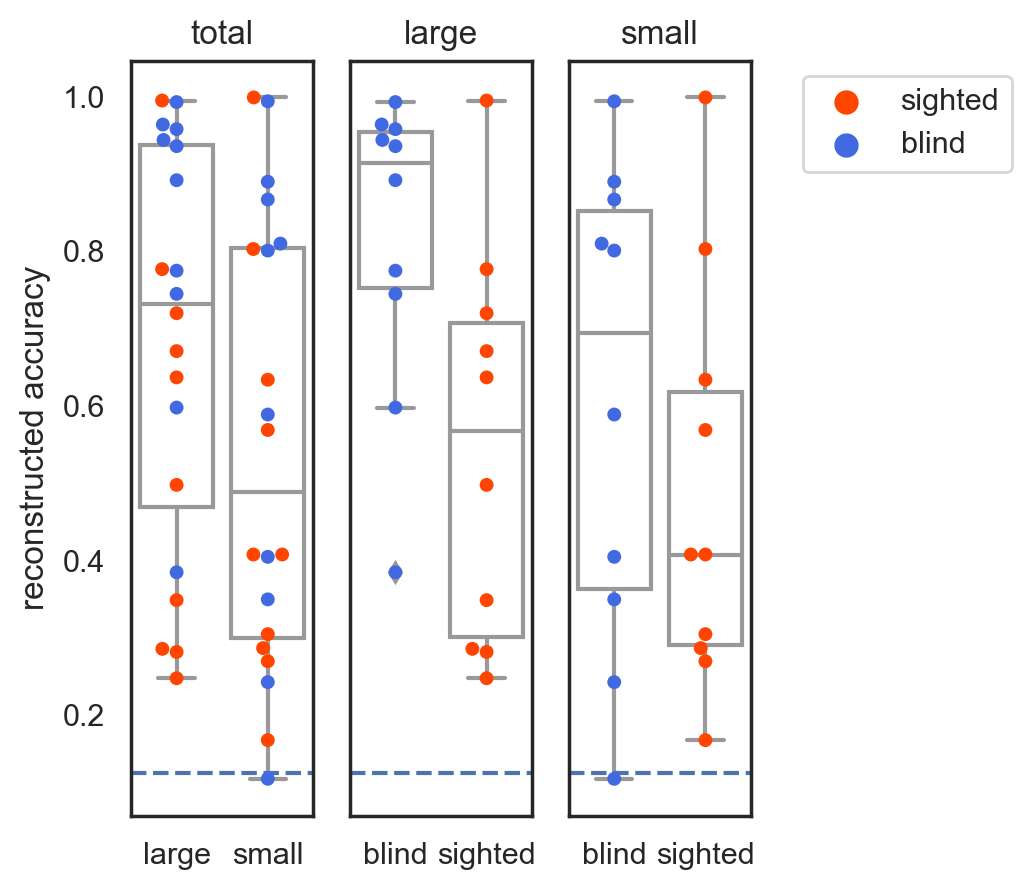

In [8]:
data = {
    'total': {'accuracy': large_stims_total + small_stims_total, 
       'groups': ['large' for a in large_stims_total] + ['small' for a in small_stims_total], 
       'group_names': ['sighted', 'blind'],
       'hue':bl+bl},
    'large': {'accuracy':large_stims_total, 
       'groups': ['blind' if a else 'sighted' for a in bl], 
       'group_names': ['sighted', 'blind'],
       'hue':bl},
    'small': {'accuracy': small_stims_total, 
       'groups': ['blind' if a else 'sighted' for a in bl], 
       'group_names': ['sighted', 'blind'],
       'hue':bl},
}



cf.boxplot_from_dict(data, ylabel='reconstructed accuracy')

## The main goal of this work was to compare BCI performance in blind and sighted. We can do it separately for small and large stimuli:

In [9]:
print ('\nBlind vs sighted:')
cf.accuracy_stats(large_blind+small_blind, large_sighted+small_sighted, independent=True)

print ('\nBlind vs sighted, large stims:')
cf.accuracy_stats(large_blind, large_sighted, independent=True)

print ('\nBlind vs sighted, small stims:')
cf.accuracy_stats(small_blind, small_sighted, independent=True)


Blind vs sighted:
[0.8055000000000001, 0.45299999999999996]
MannwhitneyuResult(statistic=122.0, pvalue=0.01801980563883087)  *

Blind vs sighted, large stims:
[0.936, 0.5675]
MannwhitneyuResult(statistic=15.0, pvalue=0.00800549540525858)  *

Blind vs sighted, small stims:
[0.6950000000000001, 0.408]
MannwhitneyuResult(statistic=40.0, pvalue=0.236254534162193) 


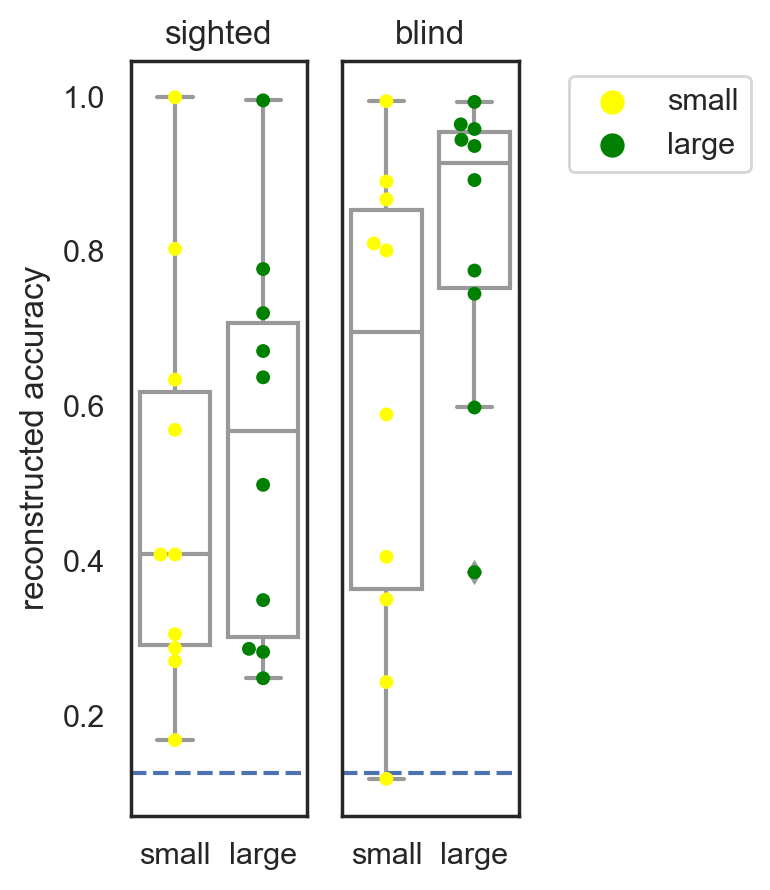

In [10]:
size = ['small' for a in small_blind] +  ['large' for a in large_blind]
data2 = {
    'sighted': {'accuracy': small_sighted + large_sighted,
       'groups': size, 
       'group_names': ['small', 'large'],
       'hue':size},
    
    'blind': {'accuracy': small_blind + large_blind,
       'groups': size, 
       'group_names': ['small', 'large'],
       'hue':size},
}
cf.boxplot_from_dict(data2, ylabel='reconstructed accuracy', figsize=(2.5,5), palette=[constants.plot_colors['small'], constants.plot_colors['large']])

## Now, we can compare classification accuracies for different fingers. There have been reports of some fingers being preferable for Braille BCI task, but here we don't see this -- the classification accuracies are essentially the same - no significant differences that would survive multiple comparison correction.

In [ ]:
%%time
fingers_total=[cf.classifier_metrics_aggergated(ds=ds, 
               subset= ds.markup.loc[(ds.markup['reg'] == 'large') &
                                     (ds.markup['finger'] == a)],
               train_size=150) for a in range(8)]

In [12]:
cf.pickler(dump=fingers_total, name='fingers_total')

MannwhitneyuResult(statistic=160.0, pvalue=0.38609061604831635) 
MannwhitneyuResult(statistic=169.5, pvalue=0.2870551570964902) 
MannwhitneyuResult(statistic=155.0, pvalue=0.23690206345262166) 
MannwhitneyuResult(statistic=167.5, pvalue=0.19332058215546455) 
MannwhitneyuResult(statistic=169.5, pvalue=0.20852760436231482) 
MannwhitneyuResult(statistic=196.0, pvalue=0.4622863641661118) 
MannwhitneyuResult(statistic=189.0, pvalue=0.38818504213665467) 
MannwhitneyuResult(statistic=160.5, pvalue=0.4936787015291841) 
MannwhitneyuResult(statistic=128.5, pvalue=0.21411358141808678) 
MannwhitneyuResult(statistic=121.5, pvalue=0.07171824451916489) 
MannwhitneyuResult(statistic=165.0, pvalue=0.44545910256063415) 
MannwhitneyuResult(statistic=151.0, pvalue=0.28644246490111286) 
MannwhitneyuResult(statistic=144.0, pvalue=0.21853793866881766) 
MannwhitneyuResult(statistic=154.5, pvalue=0.3133856853630372) 
MannwhitneyuResult(statistic=129.0, pvalue=0.044550286327134224)  *
(2, 4) MannwhitneyuResult(

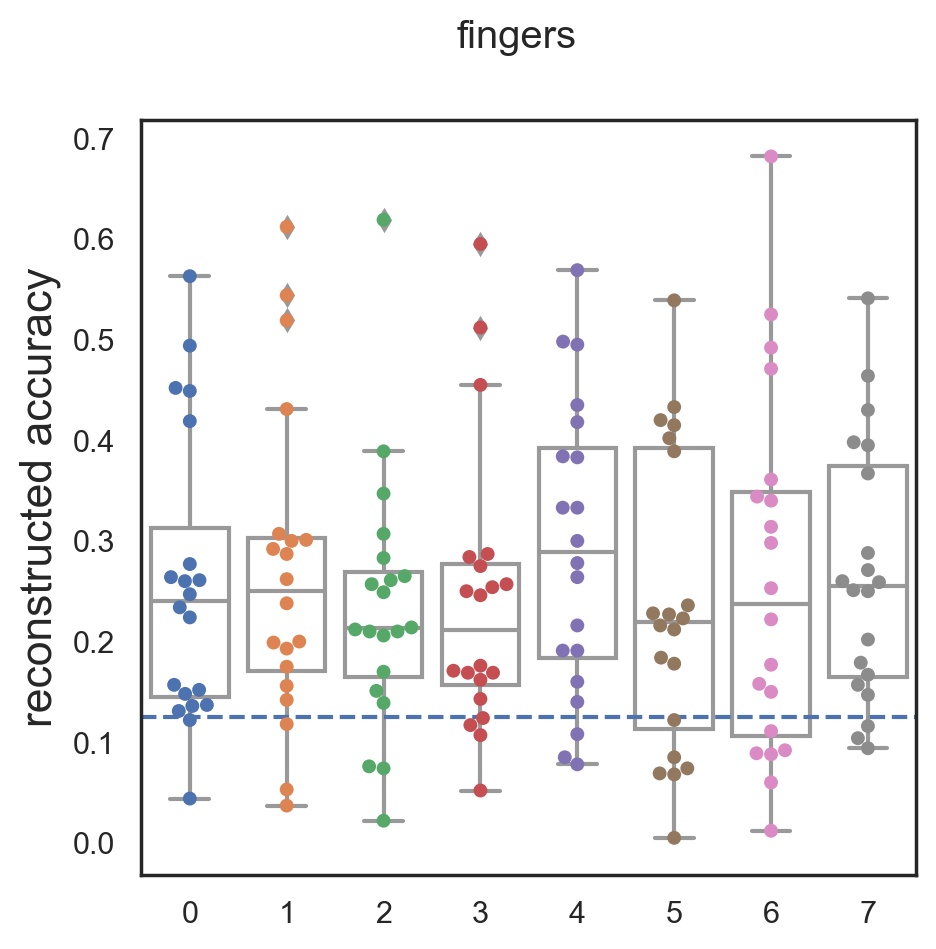

In [13]:
with plt.rc_context():
    plt.rc("figure", figsize=(5,5))
    cf.boxplot(*fingers_total, xticks=[str(a) for a in range(8)], ylabel='reconstructed accuracy')
    plt.suptitle('fingers')
cmb=([a for a in itertools.combinations(range(8), 2)])

for a in cmb:
    m = cf.mwtest(cf.remove_outliers(fingers_total[a[0]]), cf.remove_outliers(fingers_total[a[1]]));
    if m.pvalue <0.05:
        print(a,m)

## BCI speed and information transfer rate are influenced by target selection accuracy and number of repeats. This snippet calculates the dependency of ITR and accuracy on the number of ERPs for all groups and BCI modes.

In [ ]:
%%time
totals_blind_large = []
totals_sighted_large = []
totals_blind_small = []
totals_sighted_small = []
rng=range(1, 12)

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'large') &
                             (ds.markup['blind'] == 1)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = cf.classifier_metrics_aggergated(ds, subset_blind, n_repeats=a)
    totals_blind_large.append(ts)
print ('totals_blind_large created')

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'large') &
                               (ds.markup['blind'] == 0)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = cf.classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a)
    totals_sighted_large.append(ts)
print ('totals_sighted_large created')

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'small') &
                             (ds.markup['blind'] == 1)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = cf.classifier_metrics_aggergated(ds, subset_blind, n_repeats=a)
    totals_blind_small.append(ts)
print ('totals_blind_small created')

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'small') &
                               (ds.markup['blind'] == 0)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = cf.classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a)
    totals_sighted_small.append(ts)
print ('totals_sighted_small created')
                                
tb_l = cf.create_dataframe(totals_blind_large, rng)
ts_l = cf.create_dataframe(totals_sighted_large, rng)
tb_s = cf.create_dataframe(totals_blind_small, rng)
ts_s = cf.create_dataframe(totals_sighted_small, rng)

In [15]:
cf.pickler(dump=[tb_l, ts_l, ts_s, tb_s], name='[tb_l ts_l, ts_s, tb_s]')

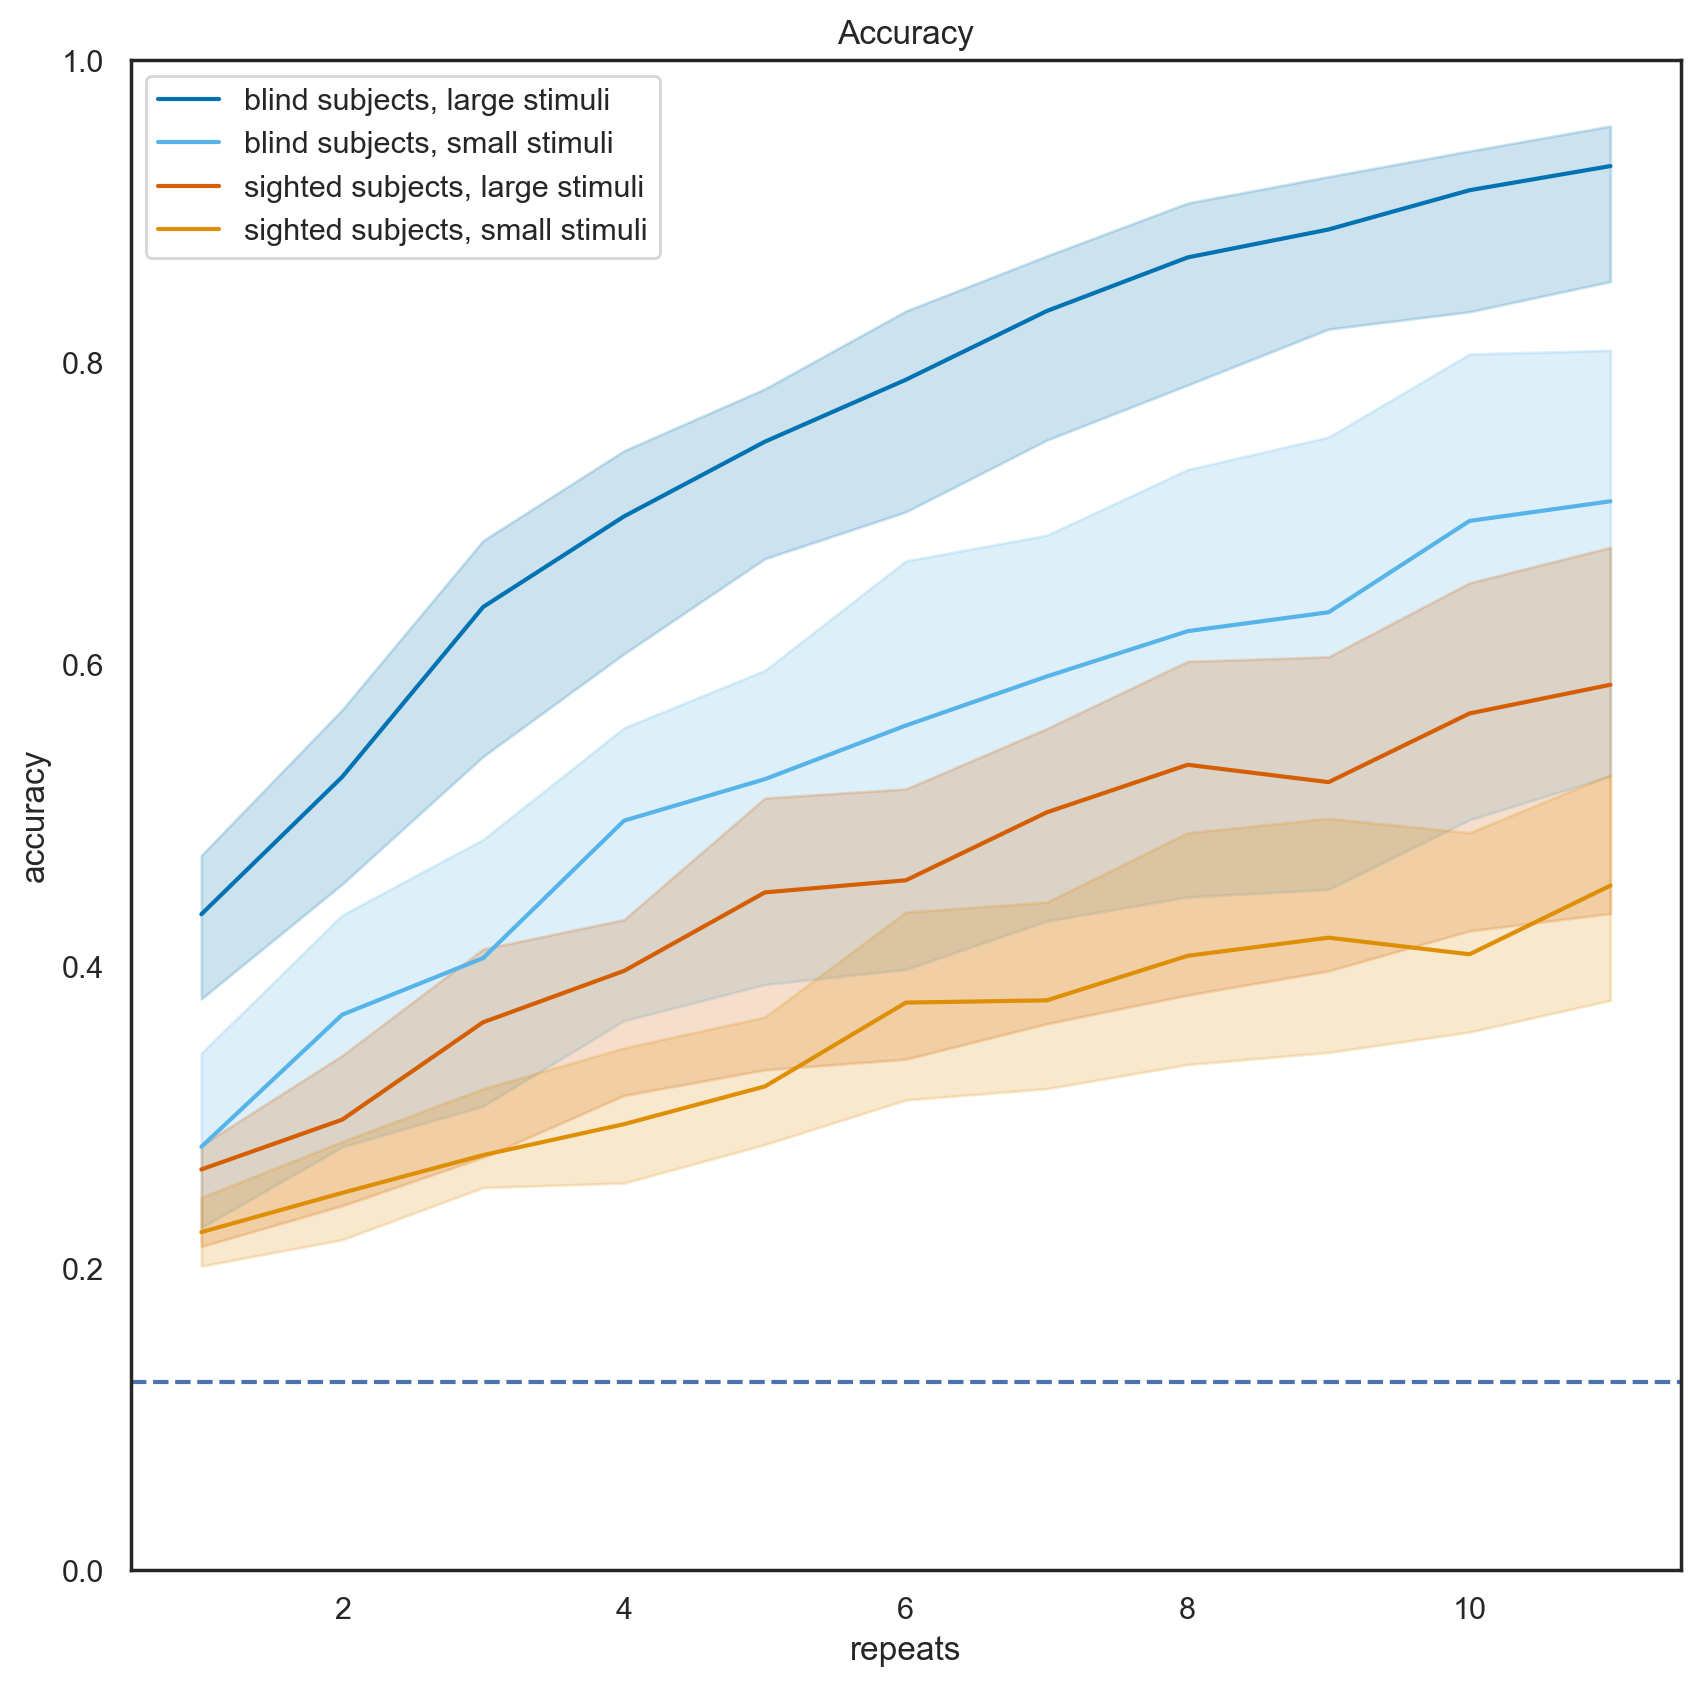

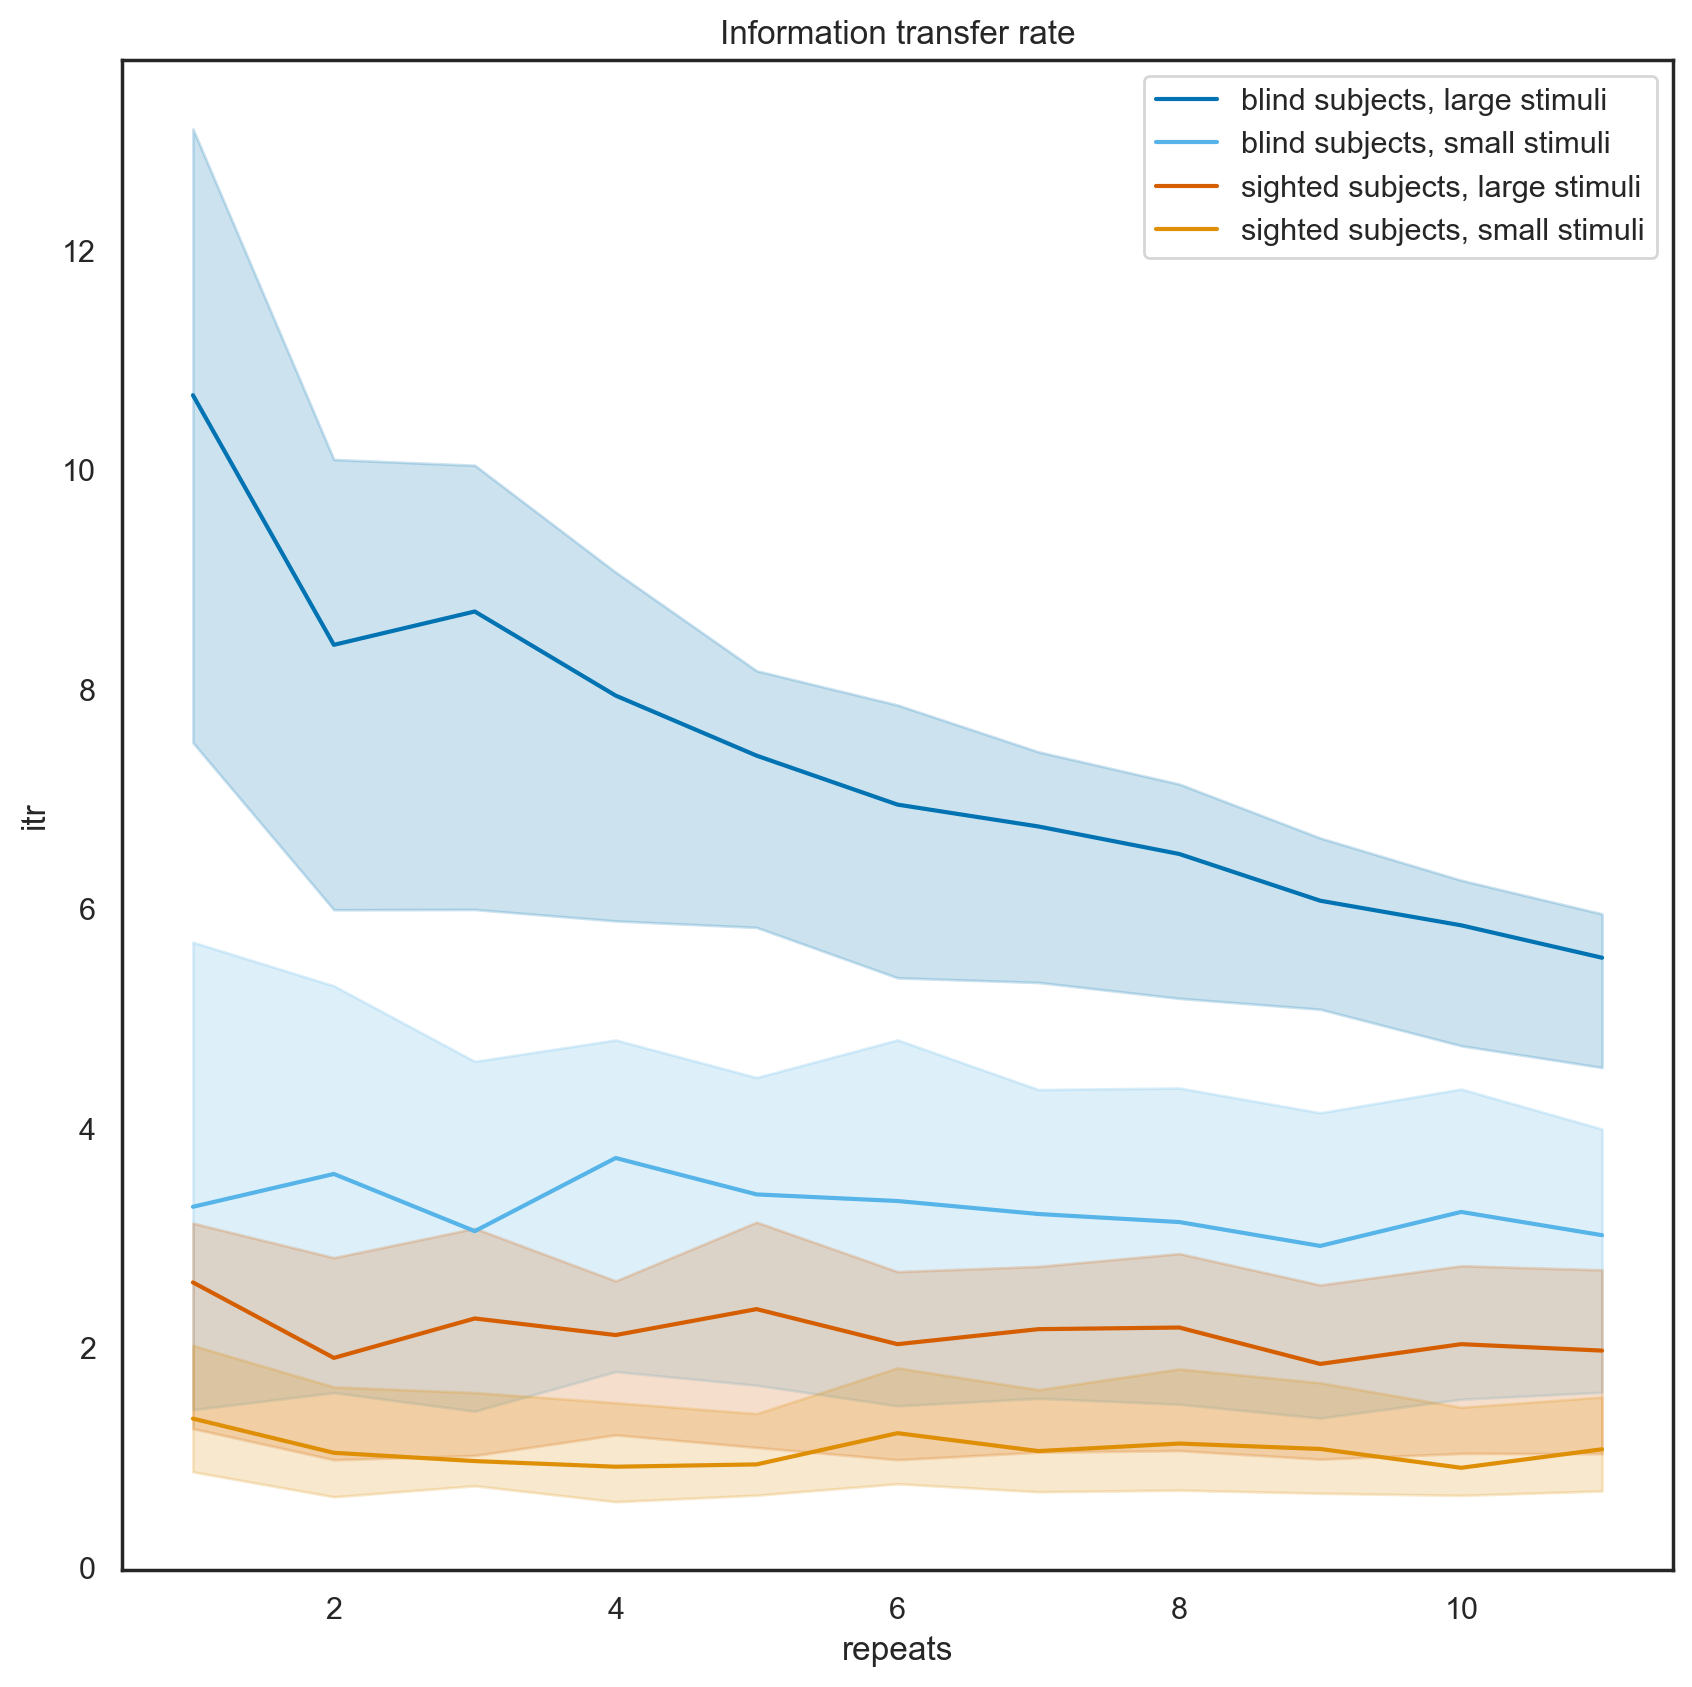

In [16]:
plt.rcParams['figure.figsize']=(10,10)

with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='accuracy', data=tb_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[0], label='blind subjects, large stimuli')
    sns.lineplot (x='repeats', y='accuracy', data=tb_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[9], label='blind subjects, small stimuli')
    sns.lineplot (x='repeats', y='accuracy', data=ts_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[3], label='sighted subjects, large stimuli')
    sns.lineplot (x='repeats', y='accuracy', data=ts_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[1], label='sighted subjects, small stimuli')
    plt.axhline(1/8, linestyle='--')
    plt.ylim(0,1)
    plt.legend(loc='upper left')
    plt.title('Accuracy')
plt.show()

with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='itr', data=tb_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[0], label='blind subjects, large stimuli')
    sns.lineplot (x='repeats', y='itr', data=tb_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[9], label='blind subjects, small stimuli')
    sns.lineplot (x='repeats', y='itr', data=ts_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[3], label='sighted subjects, large stimuli')
    sns.lineplot (x='repeats', y='itr', data=ts_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[1], label='sighted subjects, small stimuli')
    plt.title('Information transfer rate')
    
plt.show()


## We are also interested in determining how different characteristics of the subject influence BCI performance. 

### Classification accuracy vs Braille reading time in blind subjects

1. Large stimuli

In [17]:
d = ds.markup.loc[(ds.markup['reg'] == 'large') &
                          (ds.markup['blind'] == 1)]

selfreport = [ds.markup.loc[ds.markup['user']==u].iloc[0]['daily_braille_time'] for u in sorted(set(d.user))]
reading_time = [ds.markup.loc[ds.markup['user']==u].iloc[0]['reading_time'] for u in sorted(set(d.user))]

KendalltauResult(correlation=-0.5111111111111111, pvalue=0.04662257495590829)  *


C:\Users\User\Miniconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5, 0.98, 'large stimuli')

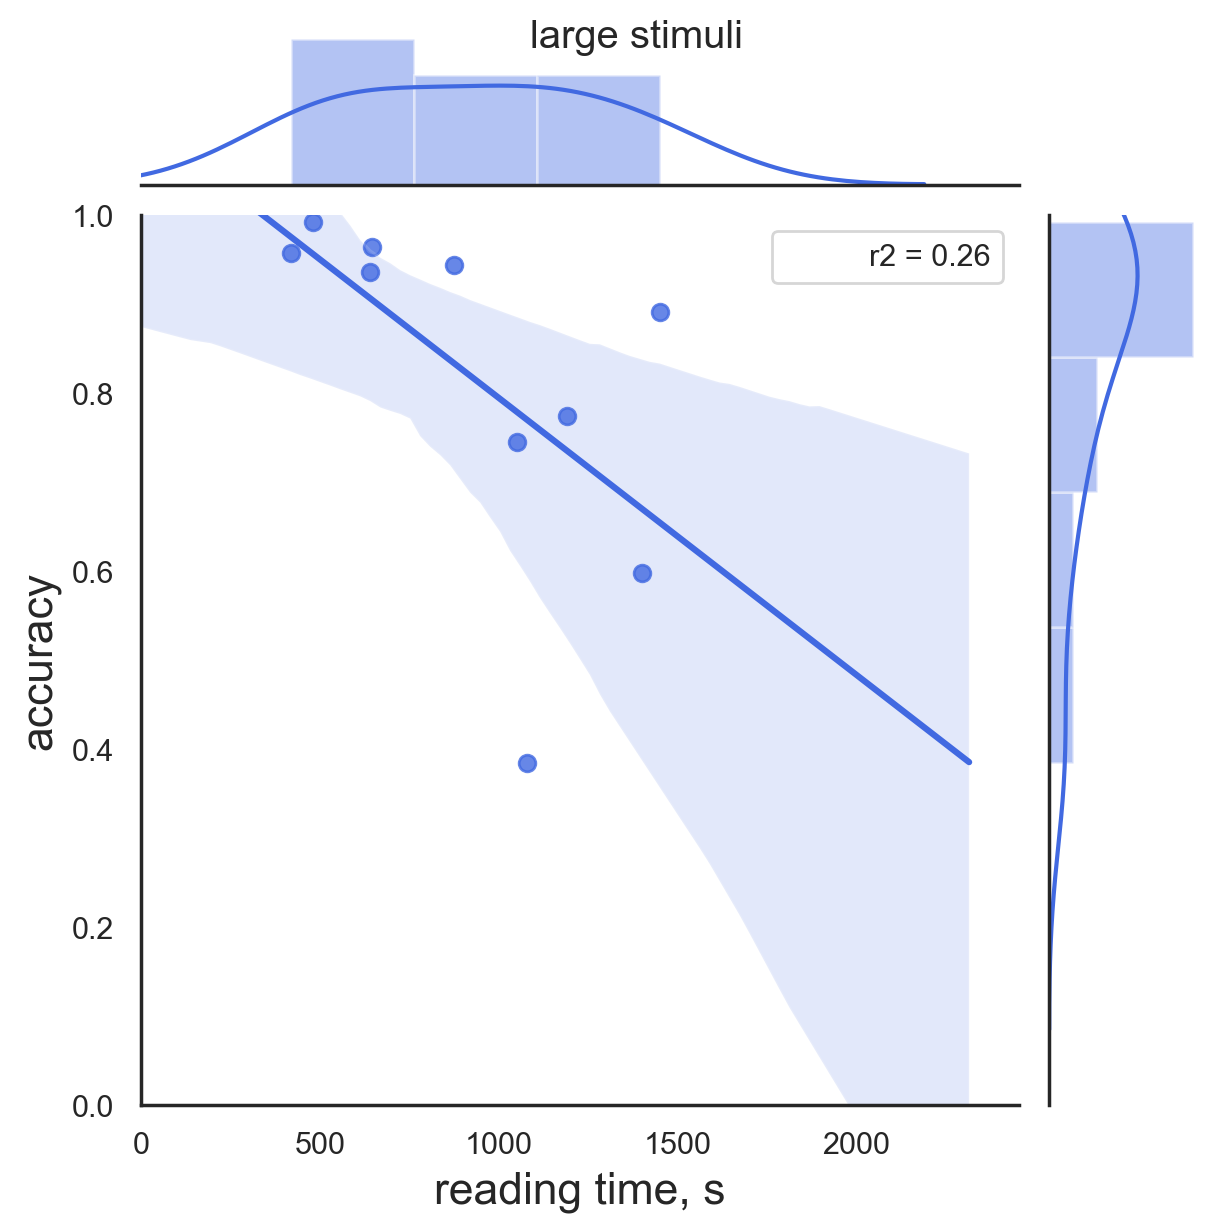

In [18]:
g = sns.jointplot (x=reading_time, y=large_blind, kind='reg', stat_func=cf.r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='reading time, s', ylabel="accuracy", fontsize=16) #convert to speed
g.ax_marg_x.set_xlim(-1)
g.ax_marg_y.set_ylim(0, 1)
plt.suptitle('large stimuli')

2. Small stimuli

KendalltauResult(correlation=-0.6444444444444444, pvalue=0.009148478835978836)  *


C:\Users\User\Miniconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5, 0.98, 'small stimuli')

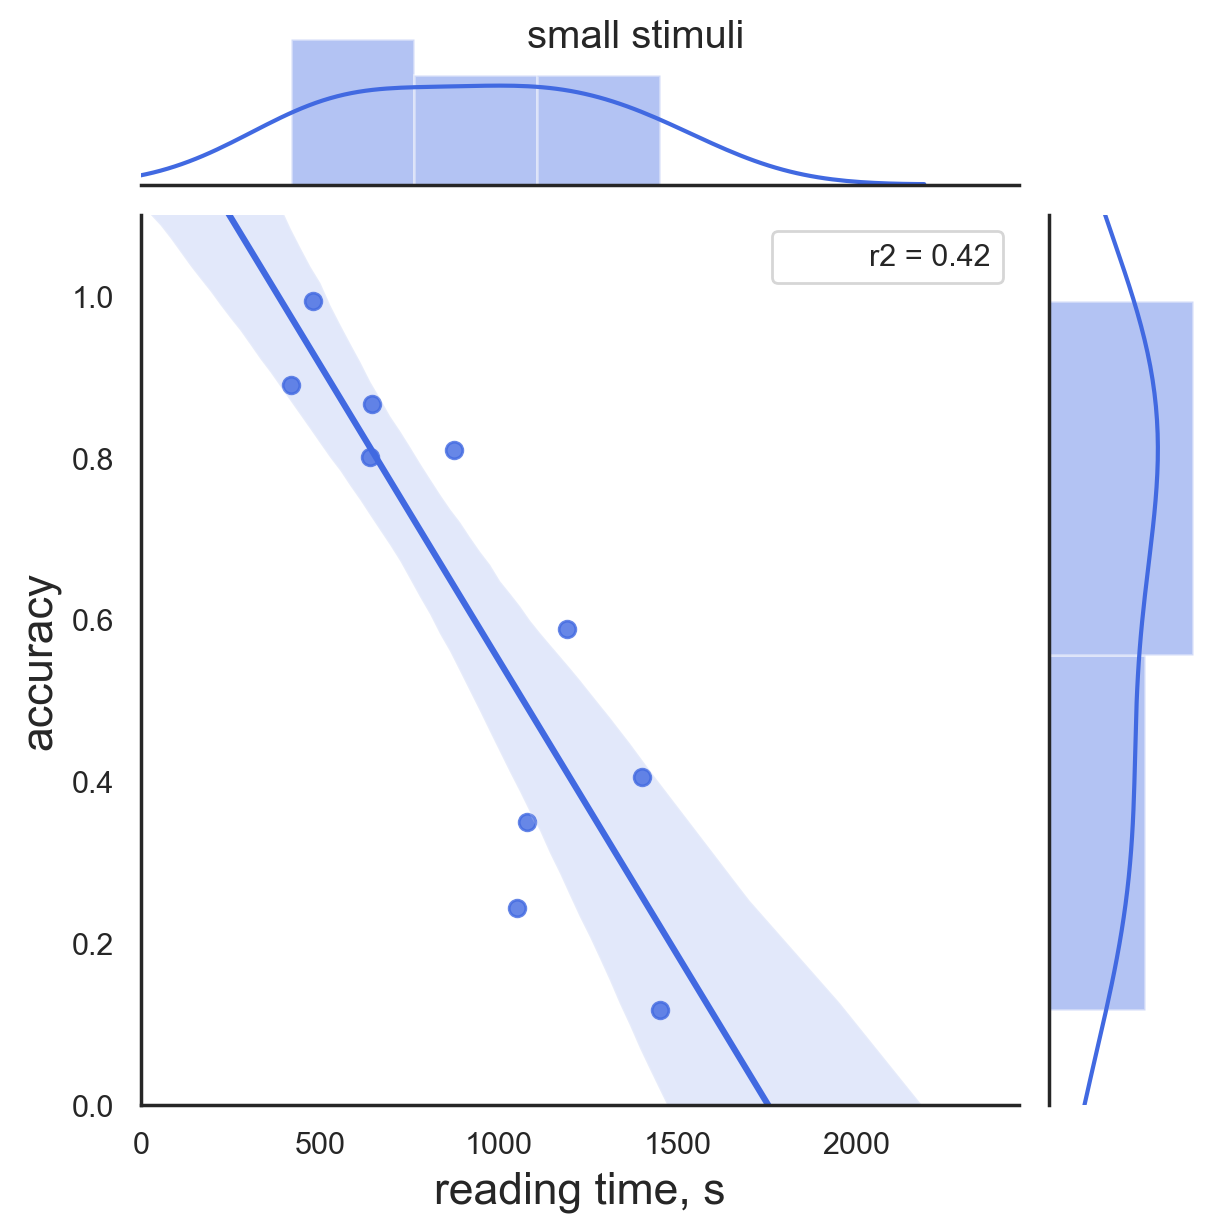

In [33]:
g = sns.jointplot (x=reading_time, y=small_blind, kind='reg', stat_func=cf.r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='reading time, s', ylabel="accuracy", fontsize=16) #convert to speed
g.ax_marg_x.set_xlim(-1)
g.ax_marg_y.set_ylim(0, 1.1)
plt.suptitle('small stimuli')

3. Both large and small stimuli

KendalltauResult(correlation=-0.5082937862097225, pvalue=0.002169854427130117)  *


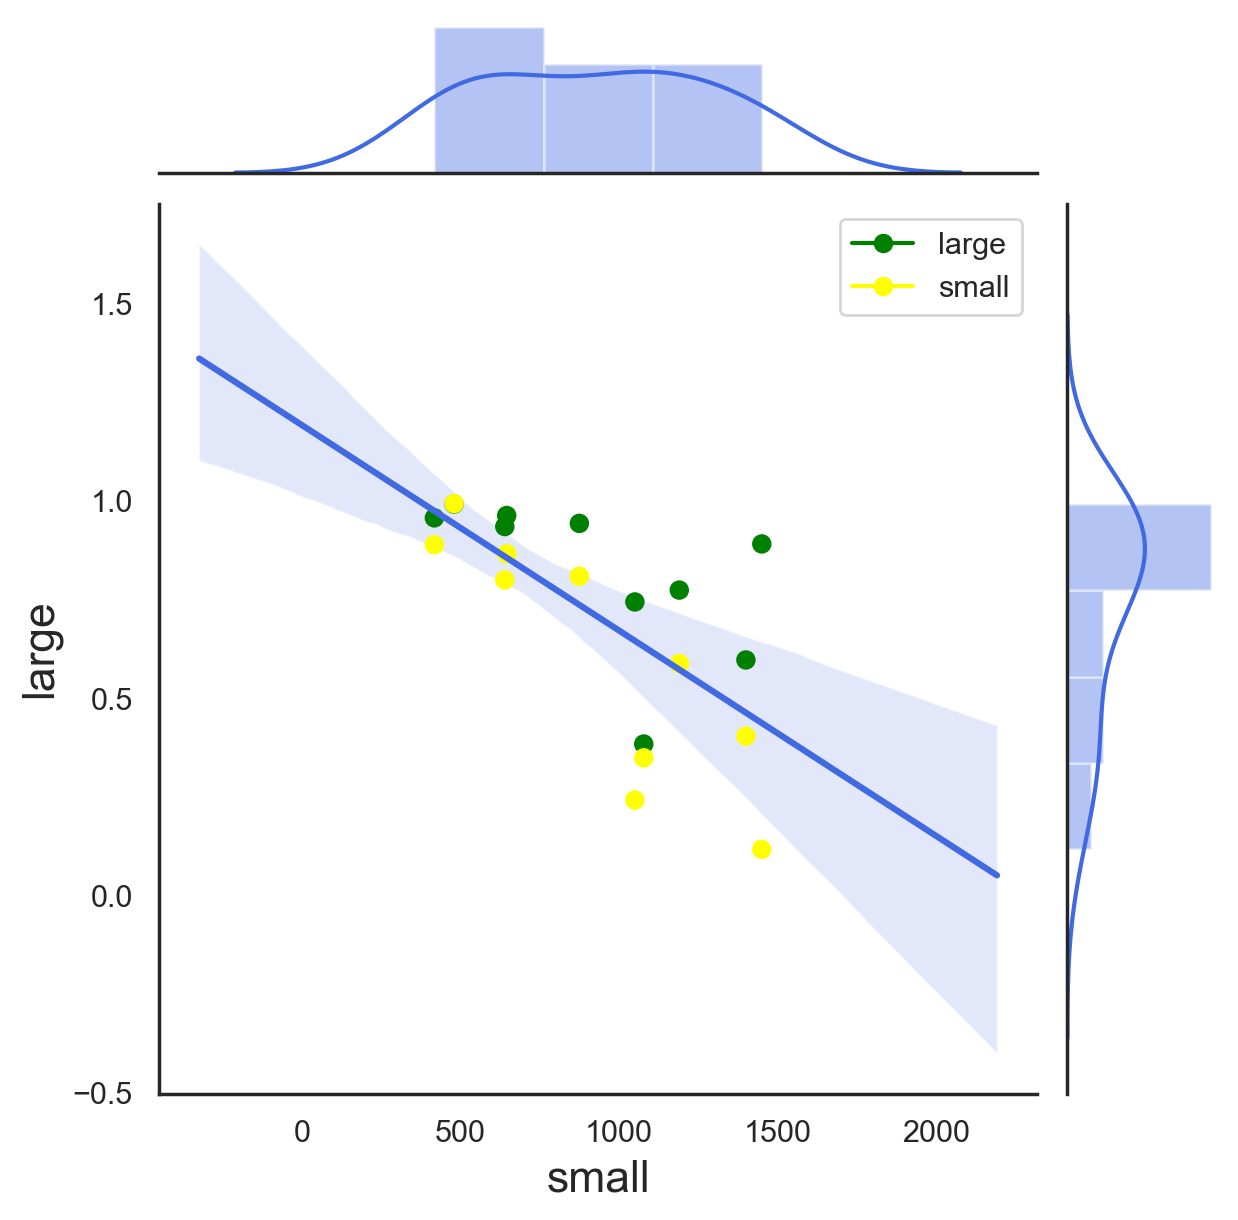

In [20]:
g = sns.jointplot (x=reading_time + reading_time,
                   y=large_blind + small_blind, 
                   kind='reg', scatter=False, stat_func=cf.r2, color=constants.plot_colors['blind'])
g.ax_joint.scatter(x=reading_time + reading_time,
                   y=large_blind + small_blind, 
                   c=[constants.plot_colors['large']]*10 + [constants.plot_colors['small']]*10)
legend_elements = [Line2D([0], [0], marker='o', color=constants.plot_colors['large'], label='large',),
                    Line2D([0], [0], marker='o', color=constants.plot_colors['small'], label='small',)]

plt.legend(handles=legend_elements)
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)


4. Classification accuracy for large stimuli in blind subjects vs self-reported daily Braille reading time

No correlation!

KendalltauResult(correlation=0.18394180184548975, pvalue=0.3025337411745722) 


(0, 1)

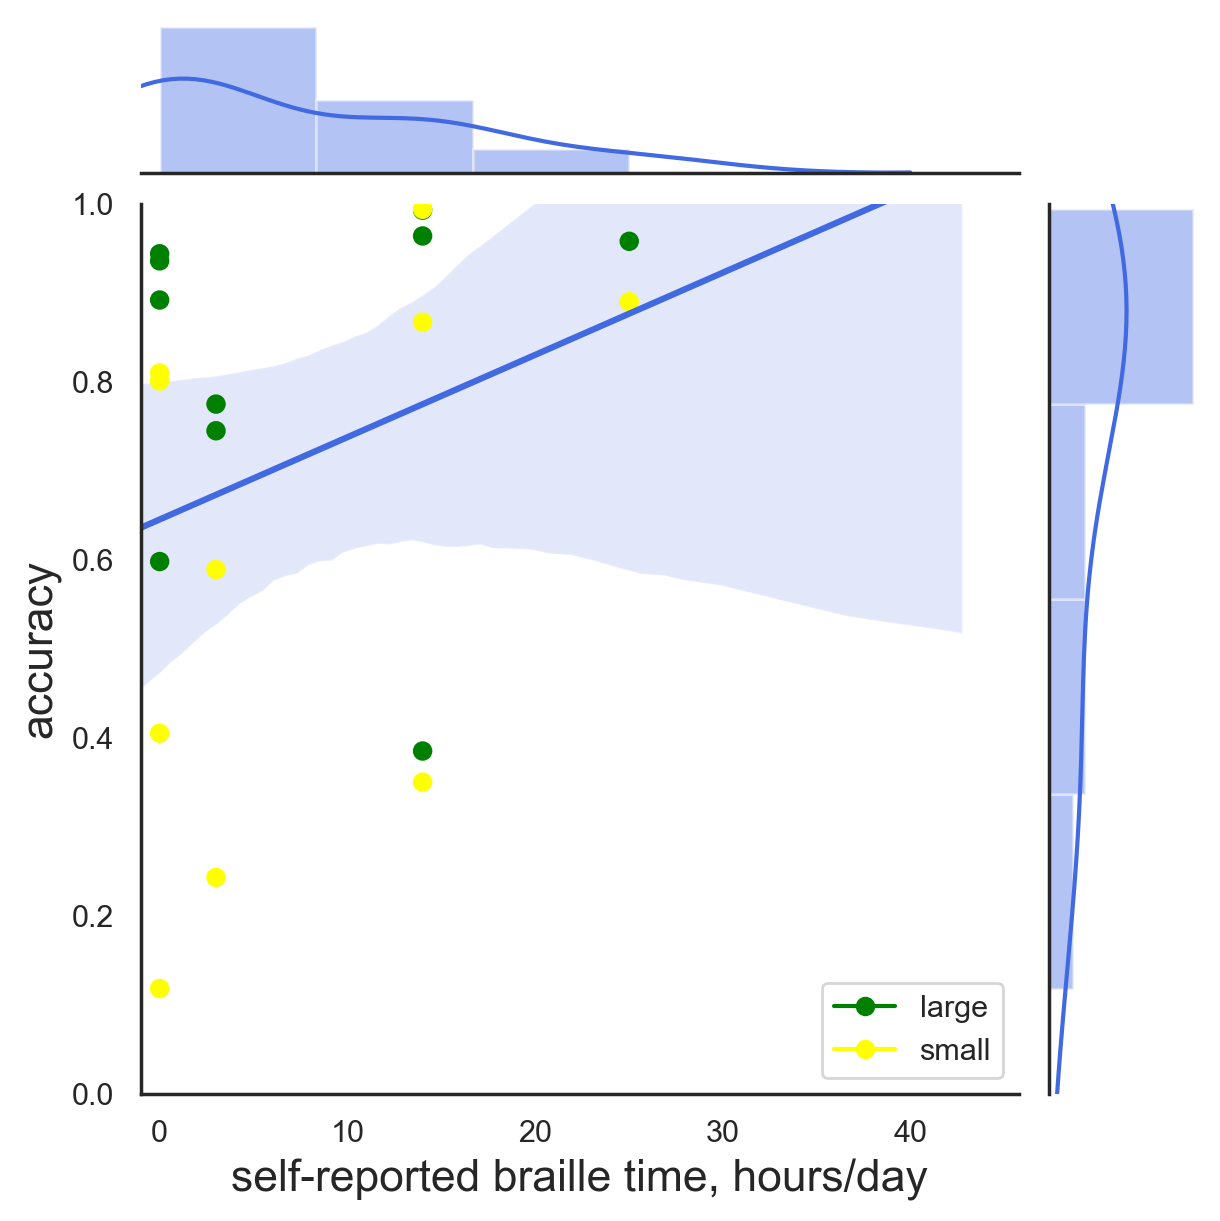

In [21]:
g = sns.jointplot (x=selfreport + selfreport,
                   y=large_blind + small_blind, 
                   kind='reg', scatter=False, stat_func=cf.r2, color=constants.plot_colors['blind'])
g.ax_joint.scatter(x=selfreport + selfreport,
                   y=large_blind + small_blind, 
                   c=[constants.plot_colors['large']]*10 + [constants.plot_colors['small']]*10)
legend_elements = [Line2D([0], [0], marker='o', color=constants.plot_colors['large'], label='large',),
                    Line2D([0], [0], marker='o', color=constants.plot_colors['small'], label='small',)]

plt.legend(handles=legend_elements)
sns.utils.axlabel(xlabel='self-reported braille time, hours/day', ylabel="accuracy", fontsize=16)

g.ax_marg_x.set_xlim(-1)
g.ax_marg_y.set_ylim(0, 1)

5. How is this possible? Maybe, self-reported metrics do not reflect actual Braille proficiency?
Right, no sifnificant correlation between reading speed and self-reported daily Braiile time.

KendalltauResult(correlation=-0.4787549991450212, pvalue=0.07217560549492462) 


(-1, 46.48924815036685)

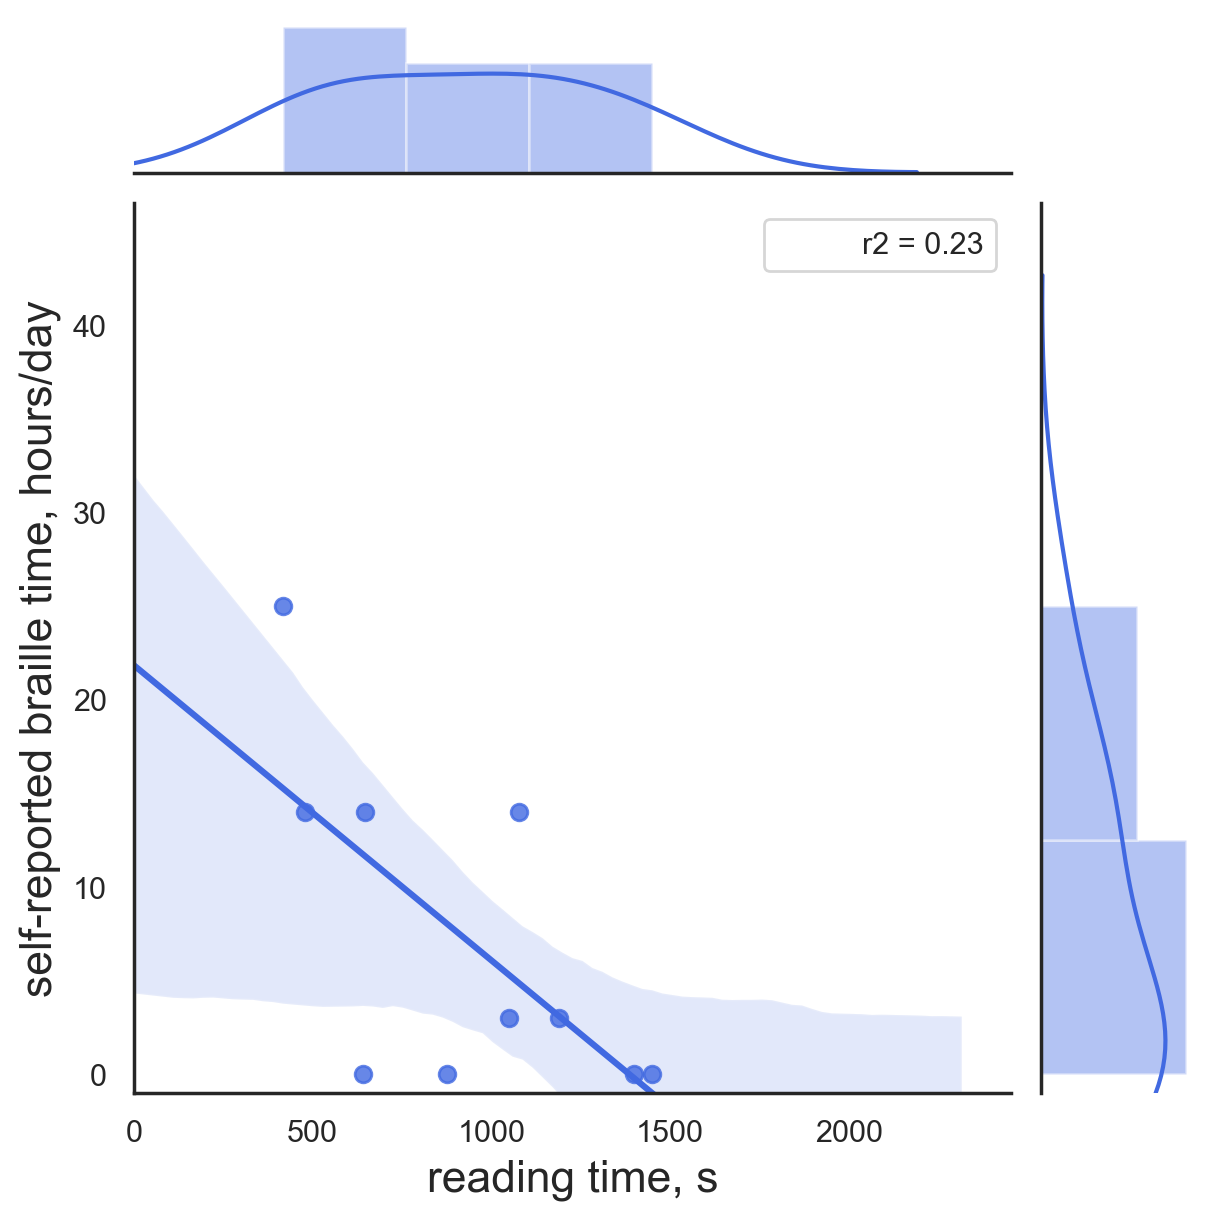

In [22]:
g = sns.jointplot (y=selfreport, x=reading_time, kind='reg', stat_func=cf.r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(ylabel='self-reported braille time, hours/day', xlabel="reading time, s", fontsize=16)
g.ax_marg_x.set_xlim(-1)
g.ax_marg_y.set_ylim(-1)

### Is classification accuracy with different stimuli consistent within the same subject?

6. Blind subjects

There is a relatively large significant correlation.

KendalltauResult(correlation=0.6888888888888888, pvalue=0.00468694885361552)  *


(0, 1.1)

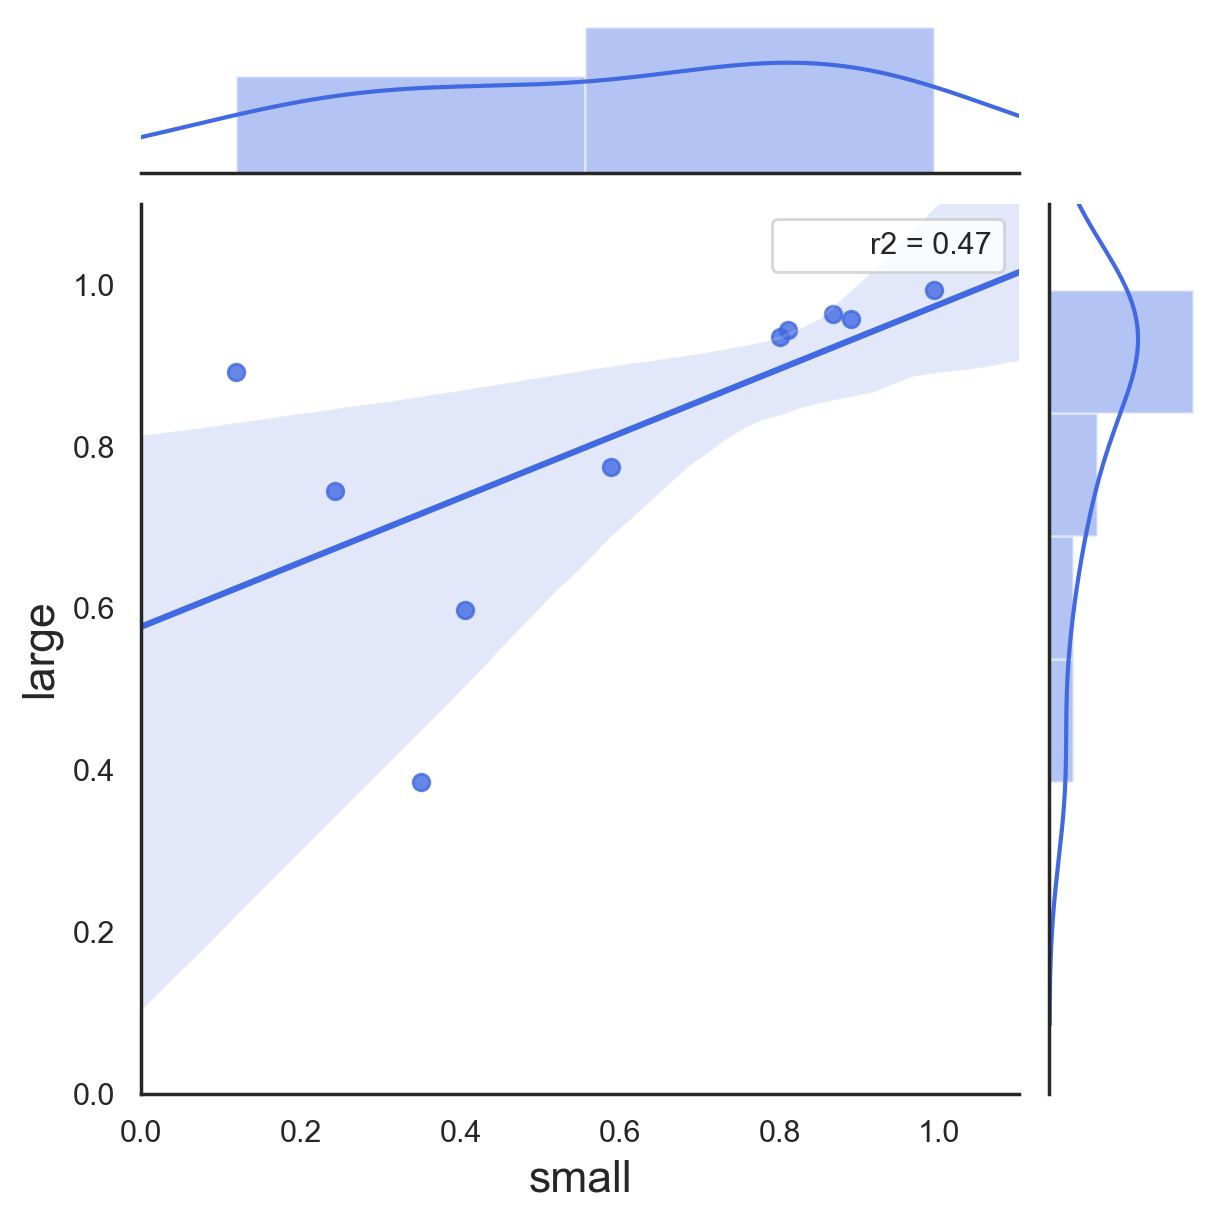

In [23]:
g = sns.jointplot (x=small_blind, y=large_blind, kind='reg', stat_func=cf.r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)
g.ax_marg_x.set_xlim(0,1.1)
g.ax_marg_y.set_ylim(0, 1.1)

7. Sighted subjects

There is a relatively large significant correlation.

KendalltauResult(correlation=0.7640931774583409, pvalue=0.002263469812035179)  *


(0, 1.1)

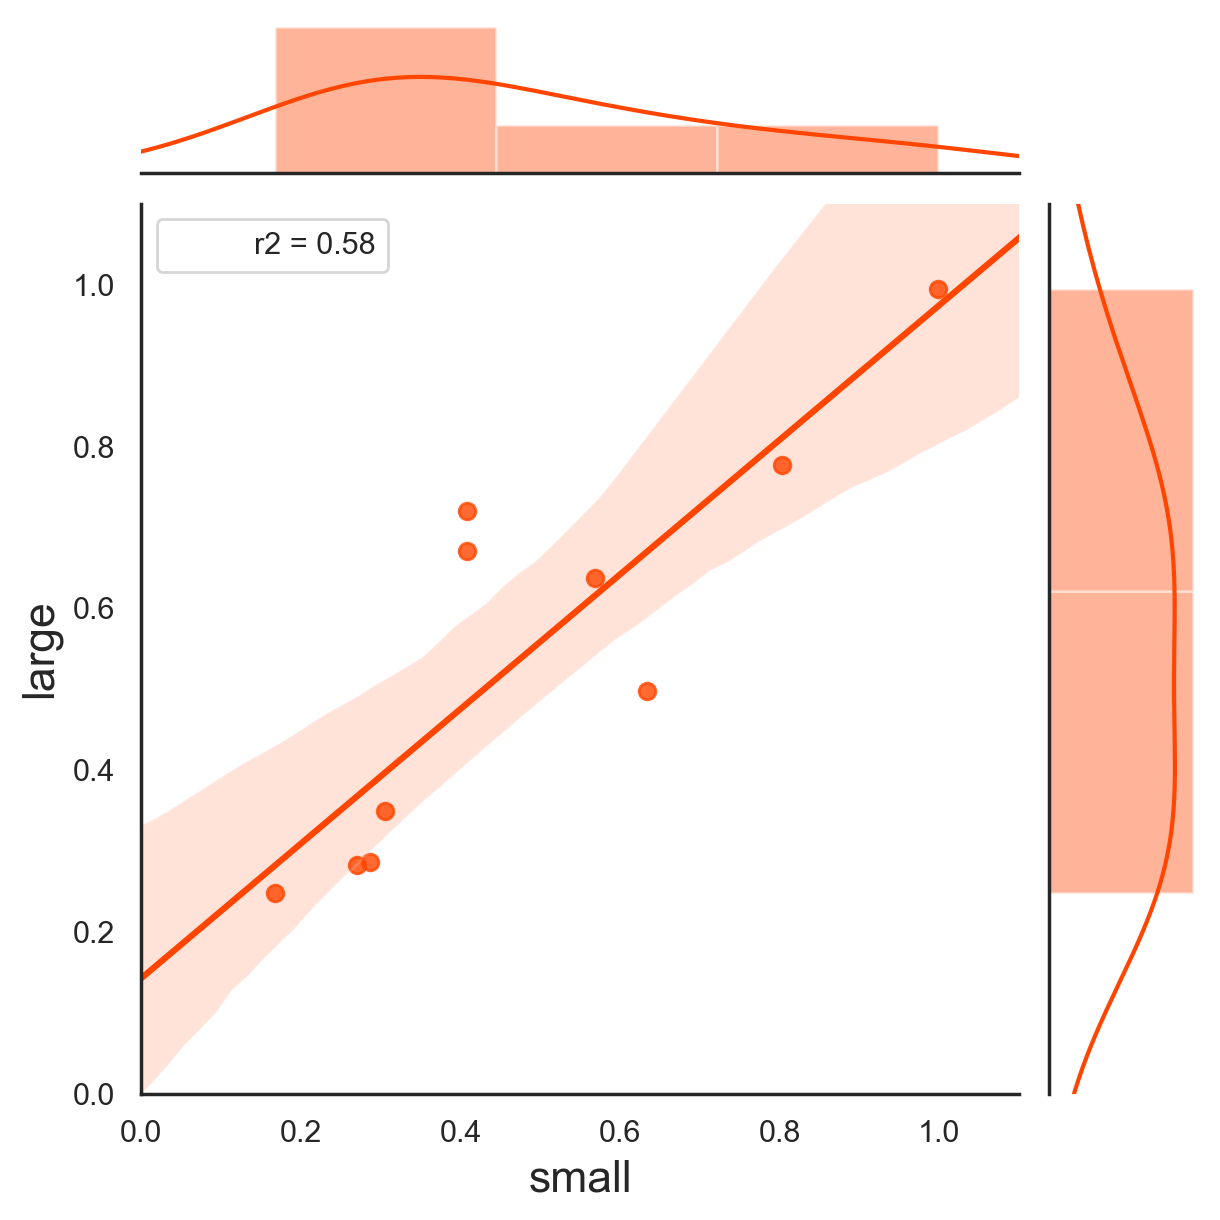

In [24]:
g = sns.jointplot (x=small_sighted, y=large_sighted, kind='reg', stat_func=cf.r2, color=constants.plot_colors['sighted'])
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)

g.ax_marg_x.set_xlim(0,1.1)
g.ax_marg_y.set_ylim(0, 1.1)

8. Both blind and sighted subjects
There is a relatively large significant correlation

KendalltauResult(correlation=0.6701870294282128, pvalue=3.7462891600498416e-05)  *


(0, 1.1)

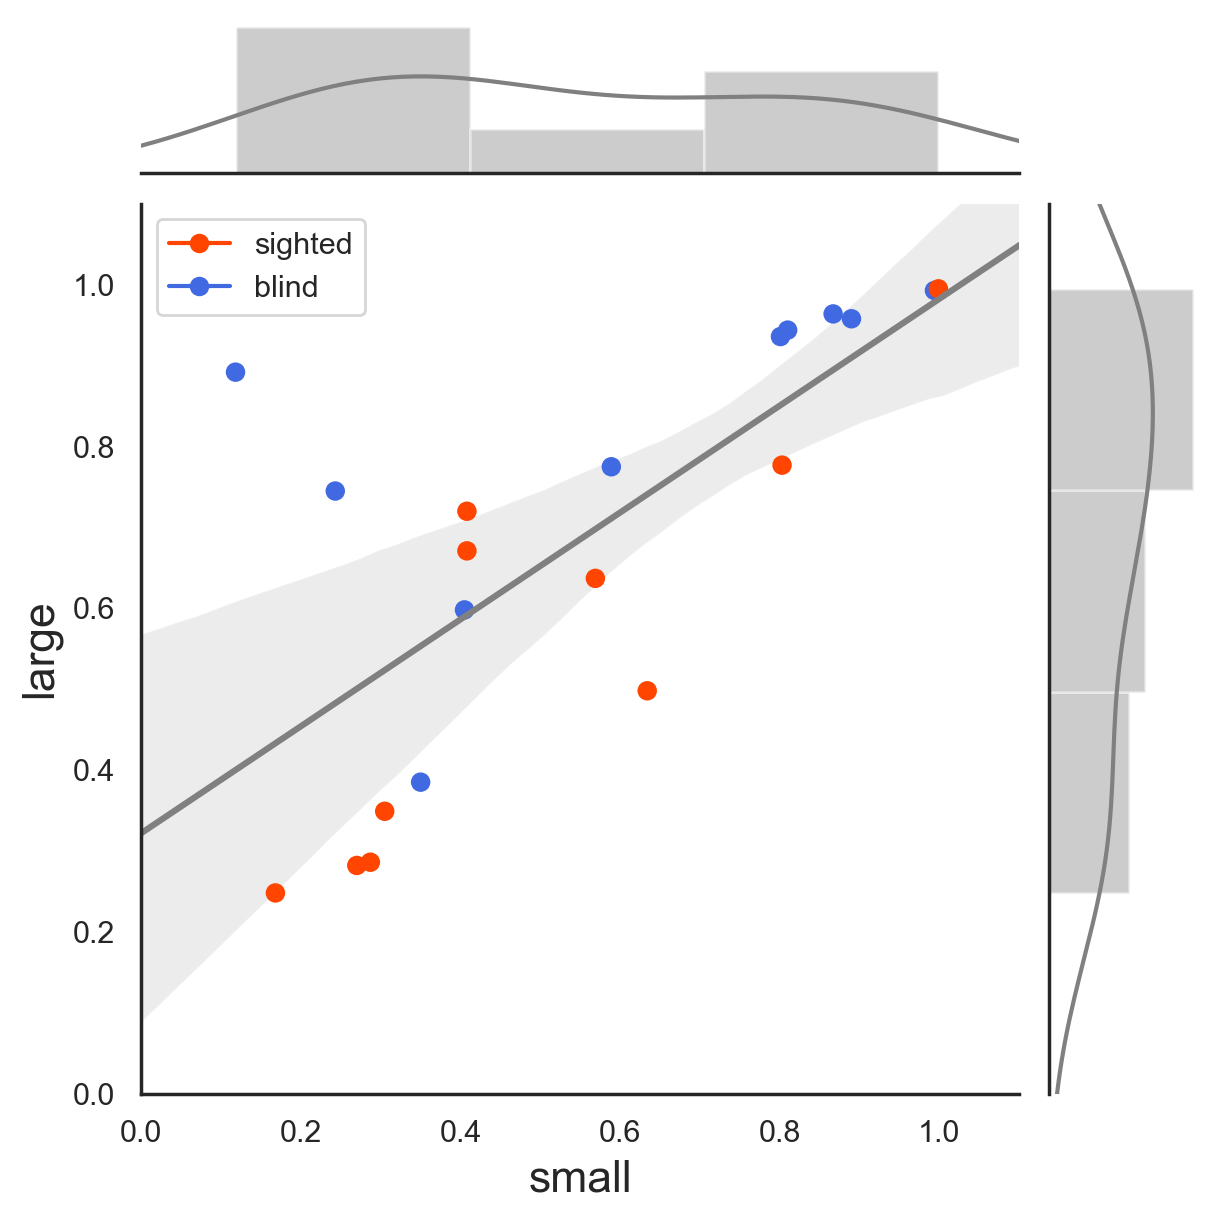

In [25]:
g = sns.jointplot (x=small_blind + small_sighted, 
                   y=large_blind + large_sighted, 
                   kind='reg', scatter=False, stat_func=cf.r2, color='gray')
g.ax_joint.scatter(x=small_blind+ small_sighted, 
                   y=large_blind + large_sighted,
                   c=[constants.plot_colors['blind']]*10 + [constants.plot_colors['sighted']]*10)

legend_elements = [Line2D([0], [0], marker='o', color=constants.plot_colors['sighted'], label='sighted',),
                    Line2D([0], [0], marker='o', color=constants.plot_colors['blind'], label='blind',)]

plt.legend(handles=legend_elements)
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)

g.ax_marg_x.set_xlim(0,1.1)
g.ax_marg_y.set_ylim(0, 1.1)

9. Age vs reading time in blind subjects

No correlation.

KendalltauResult(correlation=-0.09200874124564723, pvalue=0.7172451837847029) 


(-1, 2315.7940666393956)

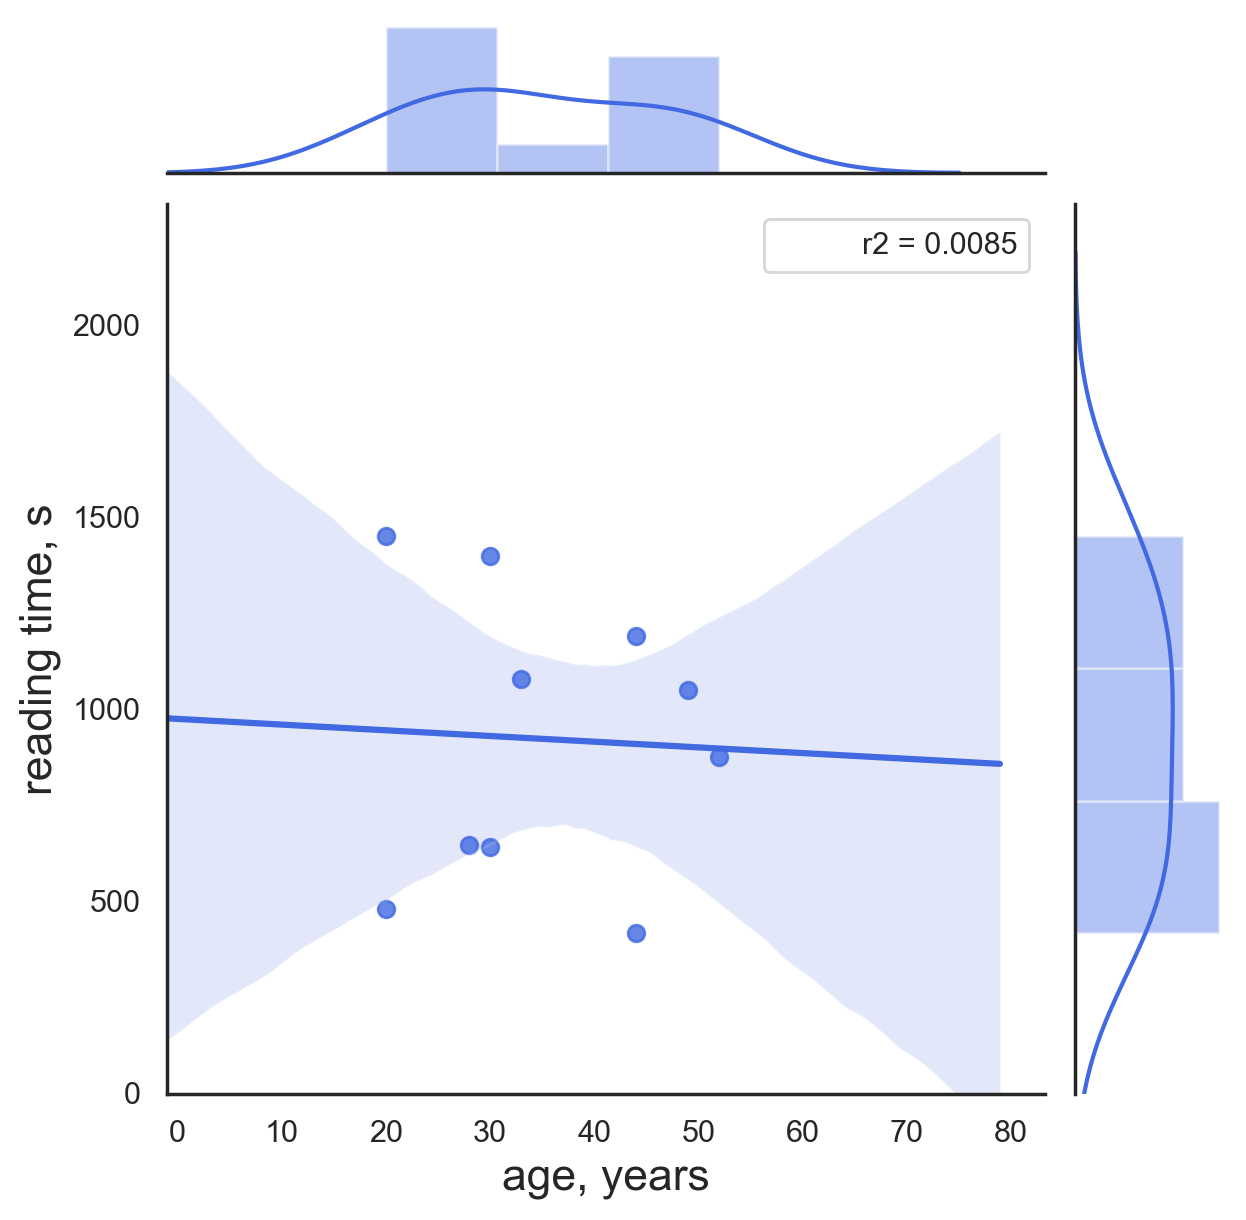

In [26]:
age = [ds.markup.loc[ds.markup['user']==u].iloc[0]['age'] for u in sorted(set(d.user))]
reading_time = [ds.markup.loc[ds.markup['user']==u].iloc[0]['reading_time'] for u in sorted(set(d.user))]

g = sns.jointplot (x=age, y=reading_time, kind='reg', stat_func=cf.r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='age, years', ylabel="reading time, s", fontsize=16)
g.ax_marg_x.set_xlim(-1)
g.ax_marg_y.set_ylim(-1)

## Can we classify blind vs sighted subjects by ERP?
Yes, we can.
It's possible to get the accuracy of 0.6 with chance level 0.5 - not that much, but reflects the same differences that were statistically tested earlier.

In [27]:
subset = ds.markup.loc[(ds.markup['reg'] == 'large') & 
                       (ds.markup['is_target'] == True)]
# blind-small
t = cf.classifier_any_groups(ds=ds, 
    subset=subset,
    y=list(subset['blind']))
t

(3200, 48, 401)


(array([0.6375  , 0.63125 , 0.6875  , 0.625   , 0.603125, 0.58125 ,
        0.684375, 0.665625, 0.653125, 0.6375  , 0.60625 , 0.66875 ,
        0.5875  , 0.603125, 0.65    , 0.634375, 0.653125, 0.61875 ,
        0.671875, 0.615625, 0.640625, 0.60625 , 0.609375, 0.578125,
        0.61875 , 0.646875, 0.640625, 0.628125, 0.69375 , 0.65    ,
        0.634375, 0.584375, 0.596875, 0.6125  , 0.60625 , 0.640625,
        0.646875, 0.63125 , 0.665625, 0.69375 , 0.65    , 0.6625  ,
        0.578125, 0.63125 , 0.61875 , 0.590625, 0.628125, 0.59375 ,
        0.671875, 0.65    , 0.621875, 0.5875  , 0.659375, 0.61875 ,
        0.63125 , 0.634375, 0.6     , 0.60625 , 0.678125, 0.634375,
        0.6625  , 0.63125 , 0.671875, 0.65625 , 0.640625, 0.596875,
        0.6     , 0.63125 , 0.65625 , 0.640625, 0.690625, 0.646875,
        0.628125, 0.59375 , 0.609375, 0.653125, 0.653125, 0.615625,
        0.625   , 0.625   , 0.63125 , 0.646875, 0.63125 , 0.60625 ,
        0.65    , 0.671875, 0.61875 , 0.615625, 

In [28]:
cf.pickler(dump=t, name='blind_vs_sighted_large')

In [29]:
subset = ds.markup.loc[(ds.markup['blind'] == 1) & 
                       (ds.markup['is_target'] == True)]
# blind-small
t = cf.classifier_any_groups(ds=ds, 
    subset=subset,
    y=list(subset['reg']))
t

(3200, 48, 401)


(array([0.546875, 0.55625 , 0.60625 , 0.575   , 0.56875 , 0.559375,
        0.553125, 0.546875, 0.58125 , 0.56875 , 0.578125, 0.5375  ,
        0.55625 , 0.5875  , 0.56875 , 0.621875, 0.509375, 0.553125,
        0.6375  , 0.621875, 0.521875, 0.628125, 0.575   , 0.584375,
        0.575   , 0.575   , 0.575   , 0.603125, 0.60625 , 0.5875  ,
        0.58125 , 0.596875, 0.603125, 0.59375 , 0.5625  , 0.534375,
        0.559375, 0.521875, 0.60625 , 0.565625, 0.55625 , 0.596875,
        0.553125, 0.603125, 0.559375, 0.590625, 0.603125, 0.50625 ,
        0.571875, 0.559375, 0.553125, 0.5625  , 0.559375, 0.565625,
        0.571875, 0.596875, 0.55625 , 0.5875  , 0.55625 , 0.56875 ,
        0.603125, 0.5125  , 0.5625  , 0.5375  , 0.6     , 0.528125,
        0.584375, 0.603125, 0.59375 , 0.55    , 0.625   , 0.575   ,
        0.565625, 0.578125, 0.590625, 0.546875, 0.5875  , 0.565625,
        0.51875 , 0.565625, 0.54375 , 0.56875 , 0.5875  , 0.6     ,
        0.540625, 0.553125, 0.56875 , 0.590625, 

In [30]:
cf.pickler(dump=t, name='large_vs_small_blind')

In [31]:
subset = ds.markup.loc[(ds.markup['blind'] == 0) & 
                       (ds.markup['is_target'] == True)]
# blind-small
t = cf.classifier_any_groups(ds=ds, 
    subset=subset,
    y=list(subset['reg']))
t

(3200, 48, 401)


(array([0.509375, 0.56875 , 0.528125, 0.553125, 0.49375 , 0.515625,
        0.50625 , 0.571875, 0.54375 , 0.559375, 0.546875, 0.534375,
        0.515625, 0.5375  , 0.525   , 0.46875 , 0.534375, 0.55    ,
        0.5125  , 0.55    , 0.528125, 0.559375, 0.575   , 0.5     ,
        0.525   , 0.53125 , 0.540625, 0.49375 , 0.6     , 0.55625 ,
        0.521875, 0.525   , 0.590625, 0.559375, 0.496875, 0.60625 ,
        0.509375, 0.575   , 0.53125 , 0.515625, 0.565625, 0.53125 ,
        0.525   , 0.546875, 0.528125, 0.51875 , 0.5125  , 0.521875,
        0.51875 , 0.546875, 0.525   , 0.53125 , 0.54375 , 0.534375,
        0.540625, 0.55    , 0.534375, 0.55625 , 0.515625, 0.56875 ,
        0.55    , 0.509375, 0.546875, 0.521875, 0.528125, 0.559375,
        0.51875 , 0.54375 , 0.5     , 0.6     , 0.590625, 0.503125,
        0.54375 , 0.546875, 0.51875 , 0.521875, 0.534375, 0.525   ,
        0.496875, 0.575   , 0.54375 , 0.5125  , 0.49375 , 0.525   ,
        0.54375 , 0.54375 , 0.5375  , 0.528125, 

In [32]:
cf.pickler(dump=t, name='large_vs_small_sighted')